[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CCS-ZCU/pribehy-dat/blob/master/scripts/nlp.ipynb)

# NLP: Zpracování přirozeného jazyka

**autor**: *Vojtěch Kaše* (kase@ff.zcu.cz)

[![](https://ccs.zcu.cz/wp-content/uploads/2021/10/cropped-ccs-logo_black_space_240x240.png)](https://ccs.zcu.cz)

## Úvod a cíle kapitoly

Cílem tohoto cvičení je provést základní kvantitativní textovou analýzu některého digitalizovaného dokumentu z **Archivu Jana Patočky** ([AJP](https://archiv.janpatocka.cz/items/browse?tags=fulltext)). Omezíme se však pouze na dokumenty, u kterých je dostupný digitální přepis (tzv. fulltext). Tj. URL adresa, kterou hledáme, je adresa jakéhokoliv námi vybraného dokumentu z daného archivu pro který je dostupný přepis.

## Cvičení

In [2]:
%%capture
!pip install stanza
import requests
import stanza
stanza.download("cs")
nlp = stanza.Pipeline("cs")
from urllib.request import urlopen # pro práci w webovými adresami
from urllib.parse import quote
from bs4 import BeautifulSoup # pro práci s webovými stránkami ve formátu html
import json
import re # pro práci s regulérními výrazy
import pandas as pd # pro práci s tabulkami ve formátu dataframe
import nltk # modul pro práci s textovými daty
from nltk import tokenize
nltk.download('punkt')
import matplotlib.pyplot as plt # modul pro vytváření grafů
import numpy as np # modul pro pokročilejší matematické operac

Váš hlavní úkol je spojen s buňkou níže. V ní je potřeba nahradit obsah proměnné "url", tj. **vyměnit webovou adresu jednoho dokumentu z AJP za adresu jiného dokumentu z téhož archivu**.  Pozor, že webová adresa musí být uvnitř uvozovek. Aby se změna projevila, je třeba buňku nakonec spustit.

In [3]:
url = "https://archiv.janpatocka.cz/items/show/308"
web_text = urlopen(url).read().decode("utf-8")
soup = BeautifulSoup(web_text, "html.parser")

In [8]:
# Tato buňka slouží ke kontrole průchodu tímto cvičením. 
# Pokud toto cvičení plníte v rámci svých studijních povinností na ZČU, buňku spusťte a držte se instrukcí.
exec(requests.get("https://sciencedata.dk/shared/856b0a7402aa7c7258186a8bdb329bd3?download").text)
kontrola_pruchodu(ntb="nlp", arg1=url)

In [9]:
text_title = soup.find("div", id="item_title").get_text()
text_title

'Pražský filosofický kroužek'

In [10]:
[div for div in soup.find_all("div", class_="col span_7_of_9")][3].get_text()

'1935'

In [11]:
text_dokumentu = soup.find("div", id="trans_full").get_text()
text_dokumentu = " ".join(text_dokumentu.split())
print(text_dokumentu)

Pražský filosofický kroužek vznikl s účelem zintesivnění filosofické práce v Československu z některých popudů VIII. mezinárodního filosofického sjezdu v Praze na podnět univ. profesorů Kozáka a Utitze. Na rozdíl od způsobu práce velkých filosofických společností chce filosofický kroužek pěstovat úzkou součinnost co možná odbornou, takřka seminární, a proto neklade důraz na širokou účast veřejnosti. Pražský filosofický kroužek hodlá pořádati přednášky, diskuse, vydávati publikace a založiti filosofický archiv. Jednací řeči může býti kterýkoli jazyk. Společné práce jsou účastni Čechoslováci české i německé národnosti, kromě toho je přihlášena řada zahraničních spolupracovníků národnosti německé, francouzské, španělské, ruské aj. Program kroužku je pěstěni filosofie v duchu domácí tradice, representované jmény Komenský, Bolzano, Masaryk, to jest ve víře v universální teoretické i praktické posláni filosofie, která ovšem zde neni pochopena jako záležitost, interesujíci pouze intelekt, nýb

In [12]:
# dokument jako list slov získáme pomocí funkce "split()"
# uložíme si ho takto do nové proměnné "string_list"
string_list = text_dokumentu.split()
# prvních 20 prvků tohoto listu si nyní vypíšeme:
string_list[:20]

['Pražský',
 'filosofický',
 'kroužek',
 'vznikl',
 's',
 'účelem',
 'zintesivnění',
 'filosofické',
 'práce',
 'v',
 'Československu',
 'z',
 'některých',
 'popudů',
 'VIII.',
 'mezinárodního',
 'filosofického',
 'sjezdu',
 'v',
 'Praze']

In [13]:
### pomocí funkce "len()" spočítáme délku tohoto listu slov:
len(string_list)

1197

### Lematizace a postagging

S textem článku, tak jak se nyní nachází v proměnné "text_clanku", bychom se ale při kvantitativní textové analýze stále příliš daleko nedostali. Čeština je totiž morfologicky velice bohatý jazyk. Chceme-li např. spočítat kolikrát se v textu objevuje sloveso "mít", s textem v aktuální podobě se příliš daleko nedstaneme. Zde potřebujeme na naše textová data aplikovat dvě další procedury:


1.   lemmatizace, tj. převedení slov z textu do jejich základních tvarů (slovesa do infinitivu, podstatná jména do 1.pádu singuláru apod.)
2.   POS-tagging ("part-of-speech tags"),  tj. určení slovních druhů a mluvnických kategorií

Aplikace těchto procedur nám umožní získat data z hlediska kvantitativní textové analýzy výrazně zajímavější.

V případě češtiny se můžeme v tomto případě opřít o model pro jazykový model pro zpracování češtiny vyvinutý pro knihovnu [stanza](https://stanfordnlp.github.io/stanza/), konkrétně [stanza-cs](https://huggingface.co/stanfordnlp/stanza-cs). 


In [25]:
# vytvoříme morfoligicky zpracovanou verzi našeho textu a konvenčně si ji uložíme do proměnně `doc`.  
doc = nlp(text_dokumentu)

Tímto jsme vytvořili morfoligicky zpracovanou verzi našeho textu a konvenčně si ji uložili do proměnně `doc`. Tento objekt nyní neobsahuje pouze syrový text, ale také text rozdělený do vět, každou větu na jednotlivá slova a každému slovo je automaticky přiřazeno jeho *lemma*, morfologické určení a některé další atributy. Na tuto datovou strukturou se můžeme nyní pracovat např. následujícím způsobem:

In [28]:
data = []
for i, sentence in enumerate(doc.sentences):
  for token in sentence.words:
    data.append({
      'sent_n' : i,
      'text': token.text,
      'lemma': token.lemma,
      'upos': token.upos,
      'xpos': token.xpos
    })
data_df = pd.DataFrame(data)
data_df[30:40]

,sent_n,text,lemma,upos,xpos
30,1,Na,na,ADP,RR--4----------
31,1,rozdíl,rozdíl,NOUN,NNIS4-----A----
32,1,od,od,ADP,RR--2----------
33,1,způsobu,způsob,NOUN,NNIS2-----A----
34,1,práce,práce,NOUN,NNFS2-----A----
35,1,velkých,velký,ADJ,AAFP2----1A----
36,1,filosofických,filosofický,ADJ,AAFP2----1A----
37,1,společností,společnost,NOUN,NNFP2-----A----
38,1,chce,chtít,VERB,VB-S---3P-AAI--
39,1,filosofický,filosofický,ADJ,AAIS1----1A----


Obdobně můžeme vybrat z vět pouze lemmata slov vybraných slovních druhů:

In [29]:
lemmatized_sentences = []
for sent in doc.sentences:
  sentence_lemmata = []
  for token in sent.words:
    if token.upos in ["PROPN", "NOUN", "VERB", "ADJ"]:
      sentence_lemmata.append(token.lemma)
  lemmatized_sentences.append(sentence_lemmata)

In [31]:
lemmatized_sentences[:3]

[['pražský',
  'filosofický',
  'kroužek',
  'vzniknout',
  'účel',
  'zintesivnění',
  'filosofický',
  'práce',
  'Československo',
  'popud',
  'mezinárodní',
  'filosofický',
  'sjezd',
  'Praha',
  'podnět',
  'univ',
  'profesor',
  'Kozák',
  'Utitz'],
 ['rozdíl',
  'způsob',
  'práce',
  'velký',
  'filosofický',
  'společnost',
  'chtít',
  'filosofický',
  'kroužek',
  'pěstovat',
  'úzký',
  'součinnost',
  'odborný',
  'seminární',
  'klást',
  'důraz',
  'široký',
  'účast',
  'veřejnost'],
 ['pražský',
  'filosofický',
  'kroužek',
  'hodlat',
  'pořádat',
  'přednáška',
  'diskuse',
  'vydávat',
  'publikace',
  'založit',
  'filosofický',
  'archiv']]

V této podobě může být již vcelku zajímavé podívat se na frekvence výskytů slov, resp. jejich lematizovaných tvarů. K tomu použijeme funkce z modulu "nltk".

In [32]:
# nejprve si z naší filtrované tabulky vyxtrahujeme lemmata samotná
lemmata = [l for s in lemmatized_sentences for l in s]
# pro každý jednotlivý výraz necháme spočítat jeho počet výskytů
lemmata_freq = nltk.FreqDist(lemmata)
# vybereme např. 10 nejfrekventovanějších slov (rozumějme lemmatizovaných substantiv, adjektiv a sloves)
lemmata_most_freq = lemmata_freq.most_common(10)
print(lemmata_most_freq)

[('pojem', 23), ('duch', 12), ('prof', 10), ('akt', 10), ('spravedlnost', 9), ('filosofický', 8), ('mínění', 8), ('duchovní', 8), ('kroužek', 7), ('Utitz', 7)]


Nyní si tato data vizualizujeme.

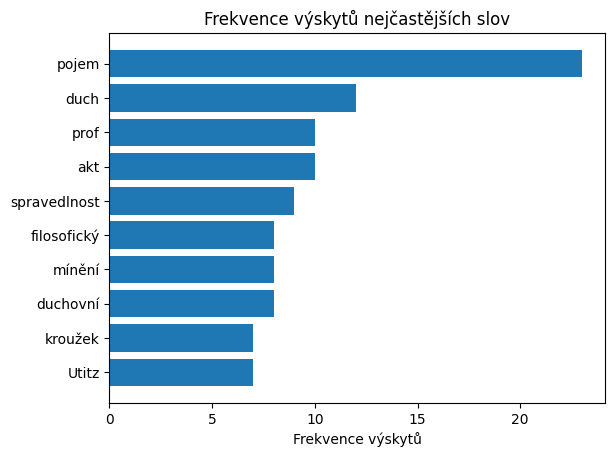

In [35]:
# kvůli horizontálnímu zobrazení prohodíme pořadí na našem listu
lemmata_mostfreq = lemmata_most_freq
lemmata_mostfreq.reverse()

# pro potřeby grafu přiřadíme hodnoty jednotlivým osám
height = [tup[1] for tup in lemmata_mostfreq]
bars = [tup[0] for tup in lemmata_mostfreq]
y_pos = np.arange(len(bars))

plt.barh(y_pos, height)
# graf si pojmenujeme a osu také
plt.yticks(y_pos, bars)
plt.xlabel('Frekvence výskytů')
plt.title('Frekvence výskytů nejčastějších slov')
# graf si zobrazíme
plt.show()

In [ ]:
kontrola_pruchodu(ntb="nlp", arg1=lemmata_most_freq)

Pokud jsme se bez chybové hlášky dostali až sem a pomocí buňky výše jsme úspěšně vykreslili graf nejfrekventovanějších termínů v námi zvoleném dokumentu z AJP, hlavní část našeho úkolu byla splněna.

## Rozšiřující analýza: Analýza všech děl z Archivu Jana Patočky 

In [38]:
def get_patocka(n):
  try:
    textdata = {}
    id = str(n)
    url = "https://archiv.janpatocka.cz/items/show/" + id
    web_text = urlopen(url).read().decode("utf-8")
    soup = BeautifulSoup(web_text, "html.parser")
    text_title = soup.find("div", id="item_title").get_text()
    date = [div for div in soup.find_all("div", class_="col span_7_of_9")][3].get_text()
    text_dokumentu = soup.find("div", id="trans_full").get_text()
    text_dokumentu = " ".join(text_dokumentu.split())
    #print(id)
    textdata["id"] = id
    textdata["title"] = text_title
    textdata["date"] = date
    textdata["rawtext"] = text_dokumentu
    return textdata
  except:
    pass

In [ ]:
data = []
for n in range(0,3000):
  textdata = get_patocka(n)
  data.append(textdata)

1
2
4
5
6
7
8
9
10
11
12
13
14
15
16
18
19
20
21
22
23
24
25
26
27
28
29
30
31
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
138
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286


In [ ]:
data_df = pd.DataFrame(data)
data_df.head(5)

In [ ]:
data_df.to_csv("../../data/patocka_all.csv")